## <span style="color: blue;">1️⃣ <b><u>Import Libraries</u></b> </span>

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import GOOG
from pandas_datareader import data as web
import talib

C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [10]:
# Define the function to get stock data
def get_stock_data(ticker, start_date, end_date, interval):
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    df.dropna(inplace=True)
    
    # Drop the 'Adj Close' column if it exists
    if 'Adj Close' in df.columns:
        df.drop(columns=['Adj Close'], inplace=True)
    
    # Ensure single-level column names
    df.columns = df.columns.get_level_values(0)  # Flatten columns
    df.columns.name = None  # Remove the name attribute from columns

    # Reset index to include Date column
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    
    # Ensure columns are in correct order
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    return df

### 4. Money Flow Index - Anand

In [29]:
# Define the MFI Strategy using backtesting.py    
class MFI_Strategy(Strategy):
    window_size = 14
    
    def init(self):
        # Initialize the necessary variables
        self.money_flow = self.data.Volume * (self.data.Close - self.data.Low) - (self.data.High - self.data.Close)
        self.mfi = self.I(self.calculate_mfi)
        print(self.mfi)

    def calculate_mfi(self):
        # Compute the MFI values
        mf_ratio = self.money_flow / self.data.Volume
        # Ensure the output has the same length as the input data
        mfi_values = pd.Series(mf_ratio).rolling(window=self.window_size).mean()  # Adjust rolling window size as needed
        # Pad the first few values with NaN or zeros, depending on your requirements
        return mfi_values.fillna(0).values  # Or use .shift() if you need specific lag handling


    def rolling_sum(self, array, period):
        # Create a rolling sum of the array with the given period
        return np.convolve(array, np.ones(period), 'valid')

    def next(self):
        # Ensure the strategy has valid MFI values
        if np.isnan(self.mfi[-1]):
            return

        # If no position is held and MFI is oversold (below 20), buy
        if not self.position and self.mfi[-1] < 20:
            self.buy()
        
        # If position is held and MFI is overbought (above 80), sell
        elif self.position and self.mfi[-1] > 80:
            self.sell()

# Fetch stock data for TD Bank (TD)
ticker = 'TD'
start_date = '2010-01-01'
end_date = '2024-01-01'
interval = '1d'  # Daily data

df = get_stock_data(ticker, start_date, end_date, interval)

# Backtest the strategy
bt = Backtest(df, MFI_Strategy, cash=10000, commission=.002)
stats = bt.run()

# Print statistics
print(stats)

# Plot the backtest results
bt.plot()

[*********************100%***********************]  1 of 1 completed
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


[0.         0.         0.         ... 0.62714318 0.59500054 0.5935722 ]
Start                     2010-01-04 00:00:00
End                       2023-12-29 00:00:00
Duration                   5107 days 00:00:00
Exposure Time [%]                   99.943214
Equity Final [$]                 20470.907981
Equity Peak [$]                   27053.50701
Return [%]                          104.70908
Buy & Hold Return [%]              105.436347
Return (Ann.) [%]                    5.259654
Volatility (Ann.) [%]               22.828015
Sharpe Ratio                         0.230403
Sortino Ratio                        0.348554
Calmar Ratio                         0.116306
Max. Drawdown [%]                  -45.222531
Avg. Drawdown [%]                   -4.366584
Max. Drawdown Duration      910 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       104.9558
Worst Tr

C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p4257', ...)

### 5.	Volume Price Trend (VPT)### Anand

In [43]:
class VPT_Strategy(Strategy):
    def init(self):
        self.vpt = self.I(self.calculate_vpt)

    def calculate_vpt(self):
        close = pd.Series(self.data.Close)
        volume = pd.Series(self.data.Volume)
        price_change = close.pct_change()
        vpt = ((price_change * volume).cumsum()).fillna(0)
        return vpt
    
    def next(self):
        if len(self.vpt) < 2:
            return

        if self.vpt[-1] > self.vpt[-2] and not self.position:
            #print(f"Buying at {self.data.Close[-1]}")
            self.buy()
        elif self.vpt[-1] < self.vpt[-2] and self.position:
            #print(f"Selling at {self.data.Close[-1]}")
            self.sell()

# Main Script
ticker = 'TD'
start_date = '2010-01-01'
end_date = '2024-01-01'
interval = '1d'

df = get_stock_data(ticker, start_date, end_date, interval)

# Backtest
bt = Backtest(df, VPT_Strategy, cash=10000, commission=.002)
stats = bt.run()
print(stats)
bt.plot()

[*********************100%***********************]  1 of 1 completed
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


Start                     2010-01-04 00:00:00
End                       2023-12-29 00:00:00
Duration                   5107 days 00:00:00
Exposure Time [%]                   99.858035
Equity Final [$]                 20654.925065
Equity Peak [$]                  27299.624085
Return [%]                         106.549251
Buy & Hold Return [%]              105.436347
Return (Ann.) [%]                    5.327074
Volatility (Ann.) [%]               22.853444
Sharpe Ratio                         0.233097
Sortino Ratio                        0.352911
Calmar Ratio                         0.117743
Max. Drawdown [%]                  -45.243265
Avg. Drawdown [%]                   -4.353929
Max. Drawdown Duration      910 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     106.705297
Worst Trade [%]                    106.705297
Avg. Trade [%]                    

C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\neelp\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p5017', ...)

In [84]:
df[df['Volume'] <= 0]  # Adjust to the correct column name


,Open,High,Low,Close,Volume,VPT


### <b> 6. </b> Heikin-Ashi Candlesticks Strategy [Anand]

[*********************100%***********************]  1 of 1 completed


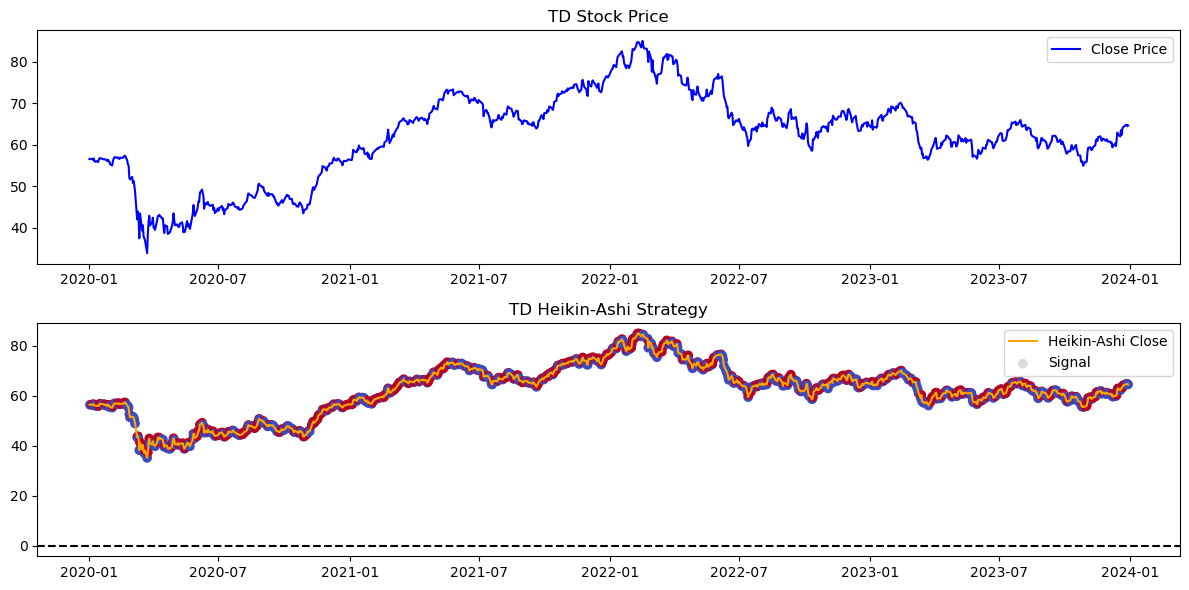

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from backtesting import Backtest, Strategy
import matplotlib.pyplot as plt

# Prepare data function
def prepare_backtest_data(ticker, start_date, end_date, interval='1d'):
    """
    Fetch and prepare stock data for backtesting.
    Ensures columns are in the correct format for backtesting.py.
    """
    # Fetch data from Yahoo Finance
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)

    # Required columns for backtesting
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Add missing columns if needed
    for col in required_columns:
        if col not in df.columns:
            if col == 'Volume':
                df[col] = 1  # Default volume
            else:
                df[col] = np.nan
    
    # Flatten MultiIndex if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Handle missing data
    df.dropna(inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Convert columns to numeric
    for col in required_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


# Define Heikin-Ashi Strategy
class HeikinAshiStrategy(Strategy):
    def init(self):
        """
        Initialize strategy by calculating Heikin-Ashi candles.
        """
        # Heikin-Ashi calculations
        self.ha_open = self.I(self.calculate_ha_open)
        self.ha_close = self.I(self.calculate_ha_close)
        
        # Track signals
        self.signal = np.zeros(len(self.data.Close))
        self.signal = self.I(self.calculate_signals)
        
    def calculate_ha_close(self):
        """
        Calculate Heikin-Ashi Close as the average of Open, High, Low, and Close.
        """
        return (self.data.Open + self.data.High + self.data.Low + self.data.Close) / 4

    def calculate_ha_open(self):
        """
        Calculate Heikin-Ashi Open as the average of the previous Open and Close.
        """
        ha_open = np.zeros_like(self.data.Close)
        ha_open[0] = (self.data.Open[0] + self.data.Close[0]) / 2  # Initialize
        for i in range(1, len(self.data.Close)):
            ha_open[i] = (ha_open[i - 1] + self.calculate_ha_close()[i - 1]) / 2
        return ha_open

    def calculate_signals(self):
        """
        Generate buy/sell signals based on Heikin-Ashi candle patterns.
        Buy when HA_Close > HA_Open and Sell when HA_Close < HA_Open.
        """
        ha_open = self.calculate_ha_open()
        ha_close = self.calculate_ha_close()
        
        signal = np.zeros(len(self.data.Close))
        signal[ha_close > ha_open] = 1  # Buy
        signal[ha_close < ha_open] = -1  # Sell
        return signal

    def next(self):
        """
        Define trading logic:
        - Buy when signal is 1.
        - Sell when signal is -1 and position exists.
        """
        if not self.position and self.signal[-1] == 1:
            self.buy()
        elif self.position and self.signal[-1] == -1:
            self.sell()


# Backtesting and Visualization
if __name__ == '__main__':
    # Define parameters
    ticker = 'TD'
    start_date = '2010-01-01'
    end_date = '2024-01-01'
    interval = '1d'

    # Prepare data
    df = prepare_backtest_data(ticker, start_date, end_date, interval)

    # Run backtest
    bt = Backtest(df, HeikinAshiStrategy, cash=10000, commission=0.002)
    stats = bt.run()

    # Display results
    print(stats)
    bt.plot()


[*********************100%***********************]  1 of 1 completed
C:\Users\Anand\AppData\Local\Temp\ipykernel_20128\2258028061.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = 'green' if df['HA_Close'][i] > df['HA_Open'][i] else 'red'
C:\Users\Anand\AppData\Local\Temp\ipykernel_20128\2258028061.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([df.index[i-1], df.index[i]], [df['HA_Open'][i], df['HA_Open'][i]], color=color, lw=1)  # Open line
C:\Users\Anand\AppData\Local\Temp\ipykernel_20128\2258028061.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

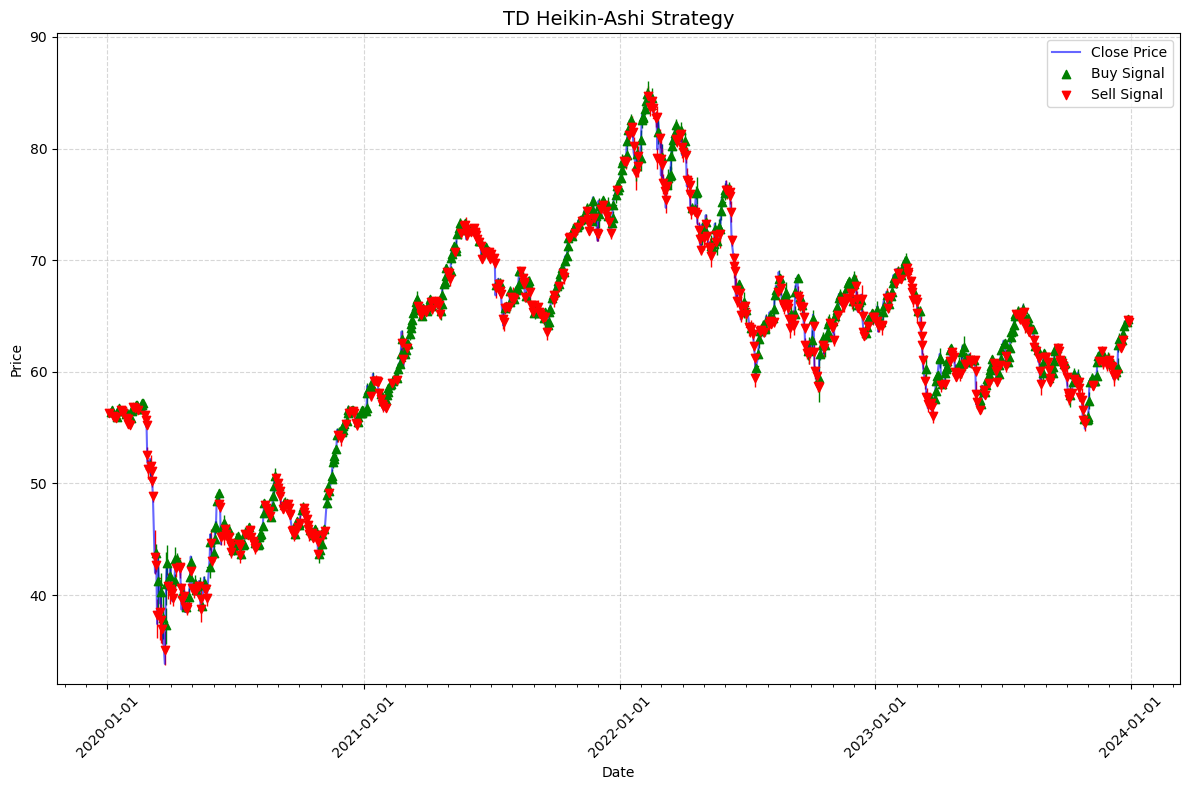

In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Heikin-Ashi Strategy Function
def heikin_ashi_strategy(df):
    # Create a copy of the original DataFrame
    ha_df = df.copy()

    # Calculate Heikin-Ashi Close: average of open, high, low, close
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    # Calculate Heikin-Ashi Open: average of previous Heikin-Ashi Open and Close
    ha_df['Open'] = (df['Open'].shift() + df['Close'].shift()) / 2

    # Calculate Heikin-Ashi High: max of the high, open, and close for each row
    ha_df['High'] = df[['Open', 'Close', 'High']].max(axis=1)

    # Calculate Heikin-Ashi Low: min of the low, open, and close for each row
    ha_df['Low'] = df[['Open', 'Close', 'Low']].min(axis=1)

    # Assign Heikin-Ashi columns to the original dataframe
    df['HA_Close'] = ha_df['Close']
    df['HA_Open'] = ha_df['Open']
    df['HA_High'] = ha_df['High']
    df['HA_Low'] = ha_df['Low']
    
    # Create Buy and Sell signals: 1 (Buy) when HA_Close > HA_Open, -1 (Sell) when HA_Close < HA_Open
    df['Signal'] = 0
    df['Signal'] = np.where(df['HA_Close'] > df['HA_Open'], 1, df['Signal'])   # Buy Signal (HA Close > HA Open)
    df['Signal'] = np.where(df['HA_Close'] < df['HA_Open'], -1, df['Signal'])  # Sell Signal (HA Close < HA Open)

    return df

# Fetch TD Bank (TD) stock data from Yahoo Finance
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Apply Heikin-Ashi strategy to the DataFrame
df = heikin_ashi_strategy(df)

# Plotting the Heikin-Ashi candles and signals
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the Heikin-Ashi Candlesticks using candlestick chart (Green for Buy, Red for Sell)
for i in range(1, len(df)):
    color = 'green' if df['HA_Close'][i] > df['HA_Open'][i] else 'red'
    ax.plot([df.index[i-1], df.index[i]], [df['HA_Open'][i], df['HA_Open'][i]], color=color, lw=1)  # Open line
    ax.plot([df.index[i-1], df.index[i]], [df['HA_Close'][i], df['HA_Close'][i]], color=color, lw=1)  # Close line
    ax.vlines(df.index[i], df['HA_Low'][i], df['HA_High'][i], color=color, lw=1)  # High-low line

# Plot the regular Close price for comparison
ax.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.6)

# Highlight Buy and Sell signals with markers
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]
ax.scatter(buy_signals.index, buy_signals['HA_Close'], marker='^', color='green', label='Buy Signal', alpha=1, zorder=5)
ax.scatter(sell_signals.index, sell_signals['HA_Close'], marker='v', color='red', label='Sell Signal', alpha=1, zorder=5)

# Format the X-axis dates for better readability
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Set y-axis limits to better visualize the price range
ax.set_ylim([df[['Low', 'HA_Low']].min().min() * 0.95, df[['High', 'HA_High']].max().max() * 1.05])

# Labels and title
ax.set_title(f'{ticker} Heikin-Ashi Strategy', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

# Grid and layout
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


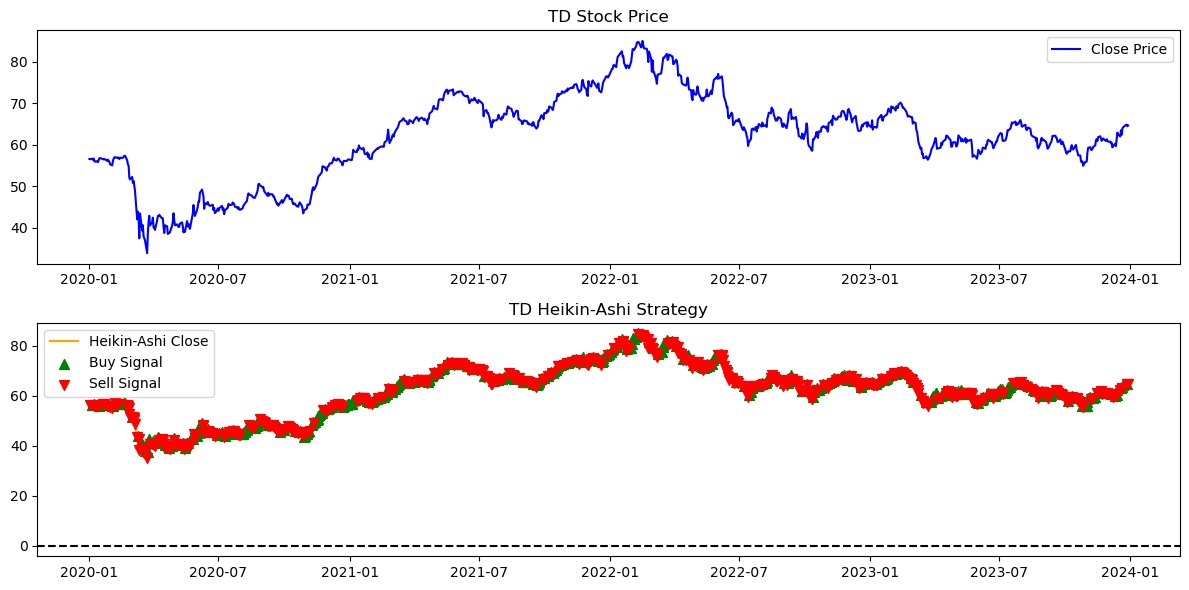

In [27]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Heikin-Ashi Strategy Function
def heikin_ashi_strategy(df):
    # Create a copy of the original DataFrame
    ha_df = df.copy()

    # Calculate Heikin-Ashi Close: average of open, high, low, close
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    # Calculate Heikin-Ashi Open: average of previous Heikin-Ashi Open and Close
    ha_df['Open'] = (df['Open'].shift() + df['Close'].shift()) / 2

    # Calculate Heikin-Ashi High: max of the high, open, and close for each row
    ha_df['High'] = df[['Open', 'Close', 'High']].max(axis=1)

    # Calculate Heikin-Ashi Low: min of the low, open, and close for each row
    ha_df['Low'] = df[['Open', 'Close', 'Low']].min(axis=1)

    # Assign Heikin-Ashi columns to the original dataframe
    df['HA_Close'] = ha_df['Close']
    df['HA_Open'] = ha_df['Open']
    
    # Create Buy and Sell signals: 1 (Buy) when HA_Close > HA_Open, -1 (Sell) when HA_Close < HA_Open
    df['Signal'] = 0
    df['Signal'] = np.where(df['HA_Close'] > df['HA_Open'], 1, df['Signal'])   # Buy Signal (HA Close > HA Open)
    df['Signal'] = np.where(df['HA_Close'] < df['HA_Open'], -1, df['Signal'])  # Sell Signal (HA Close < HA Open)

    return df

# Fetch TD Bank (TD) stock data from Yahoo Finance
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Apply Heikin-Ashi strategy to the DataFrame
df = heikin_ashi_strategy(df)

# Plotting the Close price and Heikin-Ashi signals
plt.figure(figsize=(12, 6))

# Plot the Close price
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker} Stock Price')
plt.legend()

# Plot Heikin-Ashi Close and Signals
plt.subplot(2, 1, 2)
plt.plot(df['HA_Close'], label='Heikin-Ashi Close', color='orange')

# Add Buy and Sell signals with labels
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

# Buy signals (green dots) with smaller markers
plt.scatter(buy_signals.index, buy_signals['HA_Close'], color='green', marker='^', label='Buy Signal', s=50, zorder=5)

# Sell signals (red dots) with smaller markers
plt.scatter(sell_signals.index, sell_signals['HA_Close'], color='red', marker='v', label='Sell Signal', s=50, zorder=5)

# Add a horizontal line at 0 for reference
plt.axhline(0, color='black', linestyle='--')

# Title and legend
plt.title(f'{ticker} Heikin-Ashi Strategy')
plt.legend()

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()


[*********************100%***********************]  1 of 1 completed


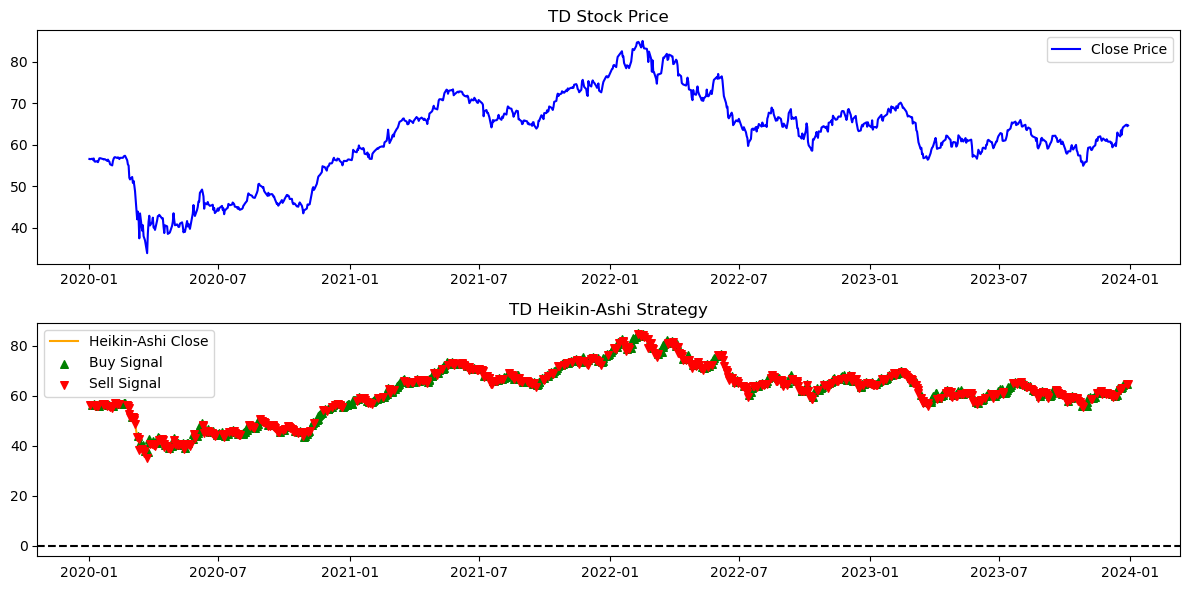

In [281]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Heikin-Ashi Strategy Function
def heikin_ashi_strategy(df):
    # Create a copy of the original DataFrame
    ha_df = df.copy()

    # Calculate Heikin-Ashi Close: average of open, high, low, close
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    # Calculate Heikin-Ashi Open: average of previous Heikin-Ashi Open and Close
    ha_df['Open'] = (df['Open'].shift() + df['Close'].shift()) / 2

    # Calculate Heikin-Ashi High: max of the high, open, and close for each row
    ha_df['High'] = df[['Open', 'Close', 'High']].max(axis=1)

    # Calculate Heikin-Ashi Low: min of the low, open, and close for each row
    ha_df['Low'] = df[['Open', 'Close', 'Low']].min(axis=1)

    # Assign Heikin-Ashi columns to the original dataframe
    df['HA_Close'] = ha_df['Close']
    df['HA_Open'] = ha_df['Open']
    
    # Create Buy and Sell signals: 1 (Buy) when HA_Close > HA_Open, -1 (Sell) when HA_Close < HA_Open
    df['Signal'] = 0
    df['Signal'] = np.where(df['HA_Close'] > df['HA_Open'], 1, df['Signal'])   # Buy Signal (HA Close > HA Open)
    df['Signal'] = np.where(df['HA_Close'] < df['HA_Open'], -1, df['Signal'])  # Sell Signal (HA Close < HA Open)

    return df

# Fetch TD Bank (TD) stock data from Yahoo Finance
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Apply Heikin-Ashi strategy to the DataFrame
df = heikin_ashi_strategy(df)

# Plotting the Close price and Heikin-Ashi signals
plt.figure(figsize=(12, 6))

# Plot the Close price
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker} Stock Price')
plt.legend()

# Plot Heikin-Ashi Close and Signals
plt.subplot(2, 1, 2)
plt.plot(df['HA_Close'], label='Heikin-Ashi Close', color='orange')

# Add Buy and Sell signals with labels
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

# Buy signals (green dots) with smaller markers
plt.scatter(buy_signals.index, buy_signals['HA_Close'], color='green', marker='^', label='Buy Signal', s=30, zorder=5)

# Sell signals (red dots) with smaller markers
plt.scatter(sell_signals.index, sell_signals['HA_Close'], color='red', marker='v', label='Sell Signal', s=30, zorder=5)

# Add a horizontal line at 0 for reference
plt.axhline(0, color='black', linestyle='--')

# Title and legend
plt.title(f'{ticker} Heikin-Ashi Strategy')
plt.legend()

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()


### <b> 7. </b> Renko Chart Strategy [Neel]

In [73]:
def renko_strategy(df, brick_size=2):
    renko_df = df.copy()
    renko_df['Brick'] = (renko_df['Close'] // brick_size) * brick_size
    
    renko_df['Uptrend'] = renko_df['Brick'] > renko_df['Brick'].shift()
    renko_df['Downtrend'] = renko_df['Brick'] < renko_df['Brick'].shift()
    
    df['Signal'] = 0
    df['Signal'] = np.where(renko_df['Uptrend'], 1, df['Signal'])
    df['Signal'] = np.where(renko_df['Downtrend'], -1, df['Signal'])
    
    return df

### <b> 8. </b> Mean Reversion with Bollinger Bands and RSI Strategy [Neel]

In [79]:
def bollinger_bands_rsi_strategy(df, bb_period=20, rsi_period=14):
    df['MA20'] = df['Close'].rolling(window=bb_period).mean()
    df['BB_Upper'] = df['MA20'] + 2 * df['Close'].rolling(window=bb_period).std()
    df['BB_Lower'] = df['MA20'] - 2 * df['Close'].rolling(window=bb_period).std()
    
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['Signal'] = 0
    df['Signal'] = np.where((df['Close'] < df['BB_Lower']) & (df['RSI'] < 30), 1, df['Signal'])
    df['Signal'] = np.where((df['Close'] > df['BB_Upper']) & (df['RSI'] > 70), -1, df['Signal'])
    
    return df

### <b> 9. </b> Dual Moving Average Strategy [Neel]

In [83]:
def dual_moving_average_strategy(df, short_window=50, long_window=200):
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    
    df['Signal'] = 0
    df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, 0)
    df['Signal'] = np.where(df['Short_MA'] < df['Long_MA'], -1, df['Signal'])
    
    return df

## <span style="color: purple;">4️⃣ <b><u>Backtesting</u></b></span>

In [24]:
# Function to backtest a given trading strategy
def backtest_strategy(strategy, df):
    bt = Backtest(df, strategy, cash=10000, commission=.002)
    stats = bt.run()
    return stats

## <span style="color: brown;">5️⃣ <u><b>Comparing with TD Mutual Fund</b></u></span>

In [40]:
# Function to compare trading strategy with a mutual fund
def compare_with_mutual_fund(strategy_results, mutual_fund_data):
    combined_data = pd.concat([strategy_results['_equity_curve']['Equity'], mutual_fund_data], axis=1)
    combined_data.columns = ['Strategy Equity', 'Mutual Fund']
    combined_data.plot(figsize=(12, 6), title='Strategy vs Mutual Fund Comparison')
    plt.ylabel('Equity')
    plt.show()

# Function to load mutual fund data
def get_mutual_fund_data(ticker, start_date, end_date, interval='1d'):
    return get_stock_data(ticker, start_date, end_date, interval)['Close']

# Example usage with a placeholder trading strategy
def trading_strategy(df):
    # Placeholder strategy - Buy and hold
    df['Signal'] = 1
    return df